# Artificial Neural Networks Basics for Classification

This notebook demonstrates the fundamentals of Artificial Neural Networks (ANNs) for classification tasks using PyTorch. We'll build a simple neural network to learn decision boundaries on a synthetic classification dataset.

ANNs are computing systems inspired by the biological neural networks in human brains. Through this notebook, you'll learn how ANNs learn decision boundaries to classify data points and how different network architectures, activation functions, and hyperparameters affect the learning process and classification accuracy.

## Import Required Libraries

Let's start by importing the necessary libraries for implementing and visualizing neural networks.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import time

## Generate Classification Data

We'll create a synthetic classification dataset using scikit-learn's `make_classification` function. This allows us to have complete control over the complexity of our problem.

In [2]:
def generate_classification_data(n_samples=200, n_features=2, n_classes=2, random_state=42):
    """
    Generate a synthetic classification dataset.
    
    Parameters:
    -----------
    n_samples : int
        Number of data points
    n_features : int
        Number of features
    n_classes : int
        Number of classes
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    X : ndarray, shape (n_samples, n_features)
        Features
    y : ndarray, shape (n_samples,)
        Target labels
    """
    n_informative = min(n_features, 2)  # Ensure n_informative doesn't exceed n_features
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_classes=n_classes,
        n_informative=n_informative,
        n_redundant=0,
        class_sep=2.0,           # Increase class separation
        n_clusters_per_class=1,
        random_state=random_state,
        flip_y=0.1             # Reduce noise
    )
    return X, y

# Generate our dataset
X, y = generate_classification_data()
print(f"Dataset shape: X {X.shape}, y {y.shape}")

Dataset shape: X (200, 2), y (200,)


## Data Preparation and Visualization

Let's split our data into training and validation sets, standardize the features, and visualize the classification problem.

In [3]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Validation set: X_val {X_val.shape}, y_val {y_val.shape}")

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Scale the entire dataset for visualization consistency
X_scaled = scaler.transform(X)

Training set: X_train (160, 2), y_train (160,)
Validation set: X_val (40, 2), y_val (40,)


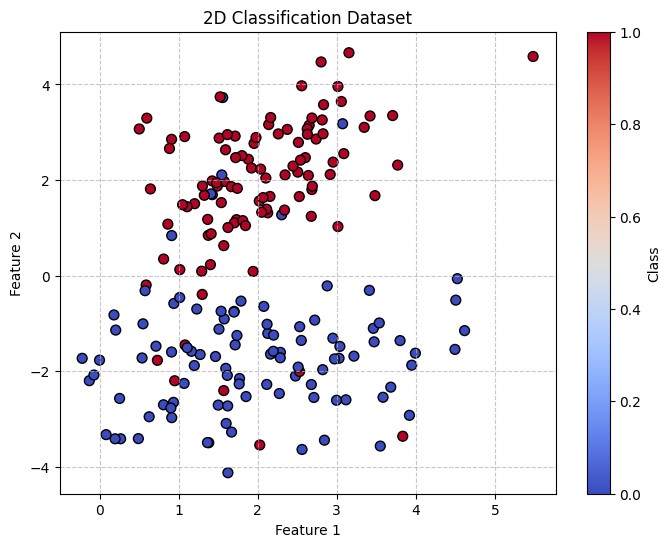

In [4]:
# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=50, edgecolors='k')
plt.title('2D Classification Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(label='Class')
plt.show()

## Neural Network Implementation

Now let's implement a configurable neural network class using PyTorch. This class allows for different layer sizes, activation functions, and regularization techniques.

In [5]:
class SimpleNN(nn.Module):
    """
    A simple neural network with configurable architecture and regularization.
    """
    def __init__(self, input_dim, hidden_layers, activation_function='ReLU', regularization='None', reg_rate=0.01):
        super(SimpleNN, self).__init__()

        self.layers = []
        prev_dim = input_dim
        for i, neurons in enumerate(hidden_layers):
            self.layers.append(nn.Linear(prev_dim, neurons))
            if activation_function == 'ReLU':
                self.layers.append(nn.ReLU())
            elif activation_function == 'Sigmoid':
                self.layers.append(nn.Sigmoid())
            elif activation_function == 'Tanh':
                self.layers.append(nn.Tanh())
            prev_dim = neurons

        # Output layer
        self.layers.append(nn.Linear(prev_dim, 1))
        self.layers.append(nn.Sigmoid())  # Classification output

        # Apply regularization
        if regularization == 'L1':
            self.regularization = nn.L1Loss()
        else: 
            self.regularization = nn.MSELoss()
            
        self.reg_type = regularization
        self.reg_rate = reg_rate

        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

## Neural Network Architecture Visualization

Let's create functions to visualize our neural network architecture, which helps in understanding the model structure.

In [6]:
def plot_neural_network(input_dim, hidden_layers, output_dim=1):
    """
    Creates a visual representation of the neural network architecture
    """
    # Remove any layers with zero neurons
    hidden_layers = [neurons for neurons in hidden_layers if neurons > 0]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calculate the maximum number of neurons in any layer for scaling
    max_neurons = max([input_dim] + hidden_layers + [output_dim])
    
    # Calculate layer positions
    n_layers = len(hidden_layers) + 2  # input + hidden + output
    layer_positions = np.linspace(0, 1, n_layers)
    
    # Colors
    input_color = "#66c2a5"   # teal for input
    hidden_color = "#8da0cb"  # blue for hidden
    output_color = "#fc8d62"  # orange for output
    
    # Draw input layer
    draw_layer(ax, layer_positions[0], input_dim, max_neurons, "Input Layer", input_color)
    
    # Draw hidden layers
    for i, neurons in enumerate(hidden_layers):
        draw_layer(ax, layer_positions[i+1], neurons, max_neurons, f"Hidden {i+1}", hidden_color)
    
    # Draw output layer
    draw_layer(ax, layer_positions[-1], output_dim, max_neurons, "Output", output_color)
    
    # Draw connections between layers
    draw_connections(ax, layer_positions, [input_dim] + hidden_layers + [output_dim], max_neurons)
    
    # Remove axes
    ax.axis('off')
    ax.set_title("Neural Network Architecture")
    
    return fig

def draw_layer(ax, x_pos, n_neurons, max_neurons, label, color):
    """Helper function to draw a layer of neurons"""
    neuron_size = 0.02
    spacing = min(0.8 / max(max_neurons, 1), 0.1)  # Adjust spacing based on max neurons
    
    # Calculate total height of layer
    layer_height = (n_neurons - 1) * spacing
    
    # Draw each neuron
    for i in range(n_neurons):
        # Calculate y position for the neuron
        if n_neurons == 1:
            y_pos = 0.5
        else:
            y_pos = 0.5 + layer_height/2 - i * spacing
        
        # Draw the neuron as a circle
        circle = plt.Circle((x_pos, y_pos), neuron_size, color=color, ec='black', zorder=4)
        ax.add_patch(circle)
    
    # Add layer label
    ax.text(x_pos, 0.1, label, ha='center', va='center', fontsize=10, fontweight='bold')

def draw_connections(ax, layer_positions, neurons_per_layer, max_neurons):
    """Helper function to draw connections between layers"""
    for i in range(len(neurons_per_layer) - 1):
        spacing_left = min(0.8 / max(max_neurons, 1), 0.1)
        spacing_right = min(0.8 / max(max_neurons, 1), 0.1)
        
        for j in range(neurons_per_layer[i]):
            # Left neuron position
            if neurons_per_layer[i] == 1:
                y_left = 0.5
            else:
                layer_height_left = (neurons_per_layer[i] - 1) * spacing_left
                y_left = 0.5 + layer_height_left/2 - j * spacing_left
            
            for k in range(neurons_per_layer[i+1]):
                # Right neuron position
                if neurons_per_layer[i+1] == 1:
                    y_right = 0.5
                else:
                    layer_height_right = (neurons_per_layer[i+1] - 1) * spacing_right
                    y_right = 0.5 + layer_height_right/2 - k * spacing_right
                
                # Draw the connection line
                ax.plot([layer_positions[i], layer_positions[i+1]], 
                        [y_left, y_right], 'k-', alpha=0.1, linewidth=0.5)

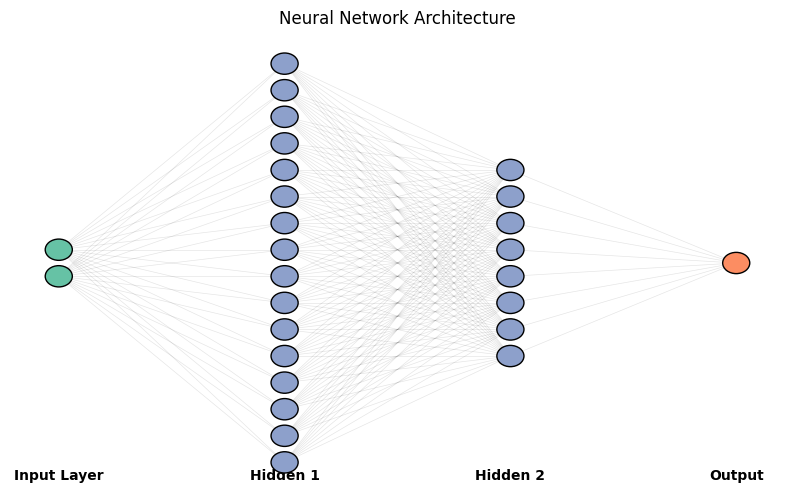

In [7]:
# Let's visualize a sample network architecture
hidden_layers = [16, 8]
nn_fig = plot_neural_network(input_dim=2, hidden_layers=hidden_layers)
plt.show()

## Training the Model

Now let's define a function to train our neural network with configurable hyperparameters such as learning rate, epochs, and regularization.

In [8]:
def train_model(X_train, y_train, X_val, y_val, epochs, learning_rate, model, criterion, optimizer):
    """
    Train the neural network model.
    
    Parameters:
    -----------
    X_train, y_train : Training data and labels
    X_val, y_val : Validation data and labels
    epochs : Number of training epochs
    learning_rate : Learning rate for optimizer
    model : Neural network model
    criterion : Loss function
    optimizer : Optimization algorithm
    
    Returns:
    --------
    train_losses, val_losses, accuracies : Lists of metrics for each epoch
    """
    train_losses = []
    val_losses = []
    accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Convert data to tensors
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Regularization
        reg_loss = 0.0
        if model.reg_type == 'L1':
            # L1 regularization
            for param in model.parameters():
                reg_loss += torch.sum(torch.abs(param))
        elif model.reg_type == 'L2':
            # L2 regularization
            for param in model.parameters():
                reg_loss += torch.sum(param.pow(2))
        
        reg_loss *= model.reg_rate  # Regularization strength
        total_loss = loss + reg_loss

        # Backward pass
        total_loss.backward()
        optimizer.step()

        # Validation loss and accuracy
        model.eval()
        val_inputs = torch.tensor(X_val, dtype=torch.float32)
        val_targets = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)
        val_losses.append(val_loss.item())

        accuracy = accuracy_score(y_val, (val_outputs.detach().numpy() > 0.5).astype(int))
        accuracies.append(accuracy)

        # Logging
        train_losses.append(total_loss.item())

    return train_losses, val_losses, accuracies

## Visualizing Decision Boundaries

Let's create a function to visualize how the decision boundary of our model evolves during training.

In [9]:
def plot_decision_boundary(X, y, model, ax=None):
    """
    Plot the decision boundary for a 2D classification problem.
    
    Parameters:
    -----------
    X : Features
    y : Labels
    model : Trained model
    ax : Matplotlib axis for plotting
    
    Returns:
    --------
    fig : Matplotlib figure
    """
    # Ensure we're only using the first two features for visualization
    X_vis = X[:, :2] if X.shape[1] > 2 else X
    
    # Create a mesh grid on which we will run our model
    h = 0.01  # Step size of the mesh
    x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
    y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Create a tensor of appropriate shape
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    
    # If the model expects more features, pad with zeros
    if X.shape[1] > 2:
        padding = np.zeros((mesh_points.shape[0], X.shape[1] - 2))
        mesh_points = np.hstack((mesh_points, padding))
    
    # Convert to PyTorch tensors
    mesh_inputs = torch.tensor(mesh_points, dtype=torch.float32)
    
    # Predict class labels for each point in the mesh
    model.eval()
    with torch.no_grad():
        mesh_outputs = model(mesh_inputs).detach().numpy()
    
    # Reshape the predictions back to the mesh grid shape
    mesh_predictions = mesh_outputs.reshape(xx.shape)
    
    # Use provided axis or create a new figure
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure
    
    # Plot the decision boundary
    ax.contourf(xx, yy, mesh_predictions > 0.5, alpha=0.3, cmap=plt.cm.coolwarm)
    
    # Plot the original data points
    scatter = ax.scatter(X_vis[:, 0], X_vis[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    
    # Add labels and title
    ax.set_title('Decision Boundary')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    return fig

## Training Metrics and Analysis

Now let's train a model and analyze its performance by plotting training metrics including loss curves and accuracy.

In [10]:
# Define model parameters
hidden_layers = [16, 8]  # Two hidden layers with 16 and 8 neurons
learning_rate = 0.01
epochs = 100
activation_function = 'ReLU'
regularization = 'None'
reg_rate = 0.01

# Create the model
model = SimpleNN(
    input_dim=X_train_scaled.shape[1], 
    hidden_layers=hidden_layers,
    activation_function=activation_function, 
    regularization=regularization, 
    reg_rate=reg_rate
)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses, val_losses, accuracies = train_model(
    X_train_scaled, y_train, X_val_scaled, y_val, 
    epochs, learning_rate, model, criterion, optimizer
)

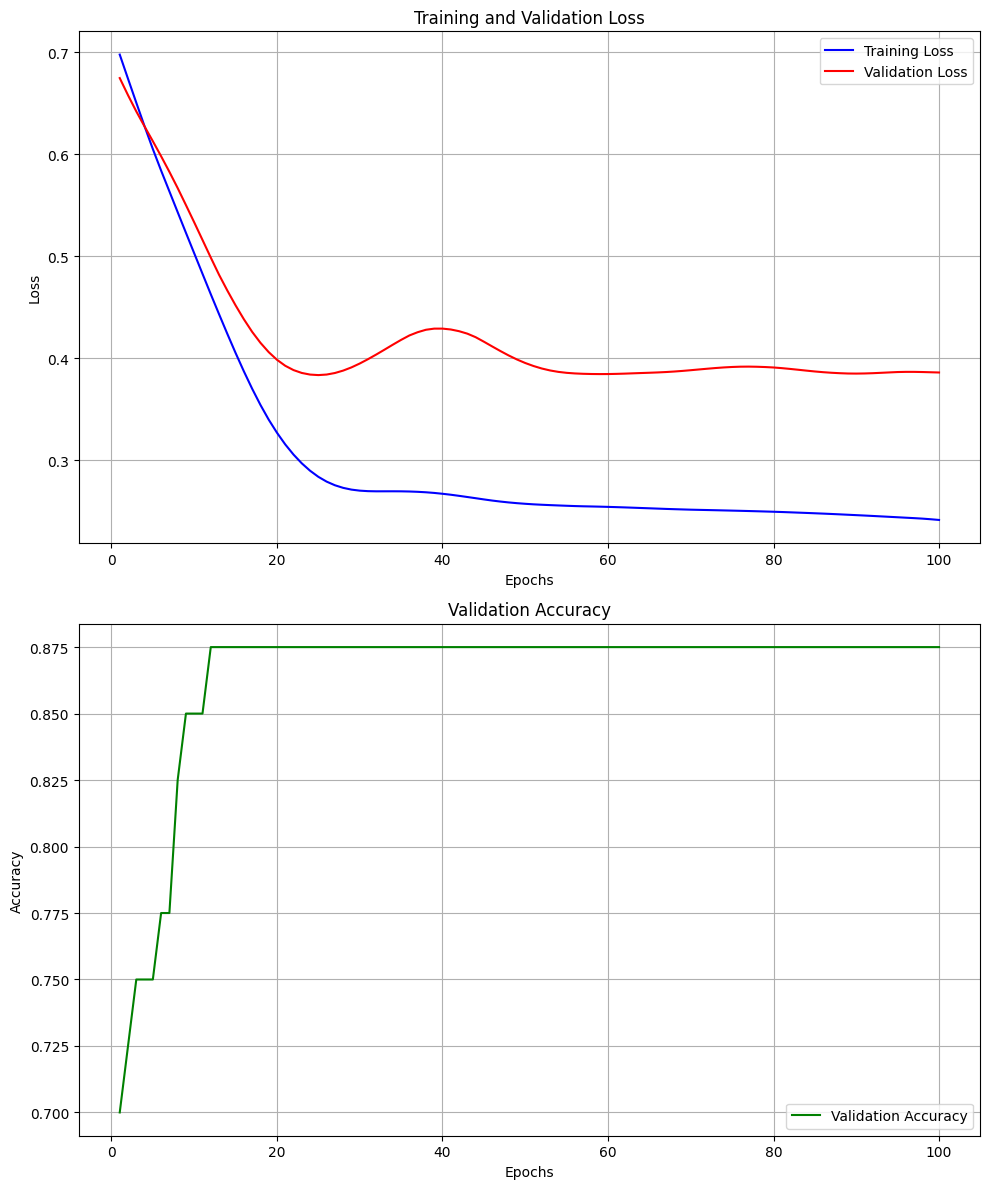

Final validation accuracy: 0.8750


In [11]:
# Plot training metrics
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot losses
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(epochs_range, accuracies, 'g-', label='Validation Accuracy')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final accuracy
print(f"Final validation accuracy: {accuracies[-1]:.4f}")

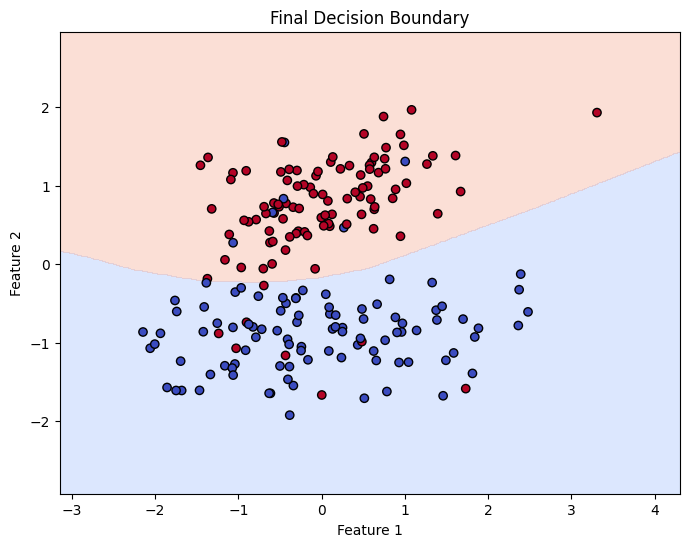

In [12]:
# Visualize the final decision boundary
fig, ax = plt.subplots(figsize=(8, 6))
plot_decision_boundary(X_scaled, y, model, ax)
plt.title("Final Decision Boundary")
plt.show()

## Experimenting with Different Parameters

Let's explore how different neural network configurations affect model performance.

### Effect of Different Activation Functions

In [13]:
# Compare different activation functions
activations = ['ReLU', 'Sigmoid', 'Tanh']
activation_results = []

for activation in activations:
    # Create model
    model = SimpleNN(
        input_dim=X_train_scaled.shape[1], 
        hidden_layers=[16, 8],
        activation_function=activation, 
        regularization='None', 
        reg_rate=0.01
    )
    
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    train_losses, val_losses, accuracies = train_model(
        X_train_scaled, y_train, X_val_scaled, y_val, 
        50, 0.01, model, criterion, optimizer
    )
    
    activation_results.append({
        'activation': activation,
        'final_accuracy': accuracies[-1],
        'train_losses': train_losses,
        'val_losses': val_losses,
        'accuracies': accuracies
    })
    
    print(f"{activation} - Final accuracy: {accuracies[-1]:.4f}")

ReLU - Final accuracy: 0.8750
Sigmoid - Final accuracy: 0.8750
Tanh - Final accuracy: 0.8750


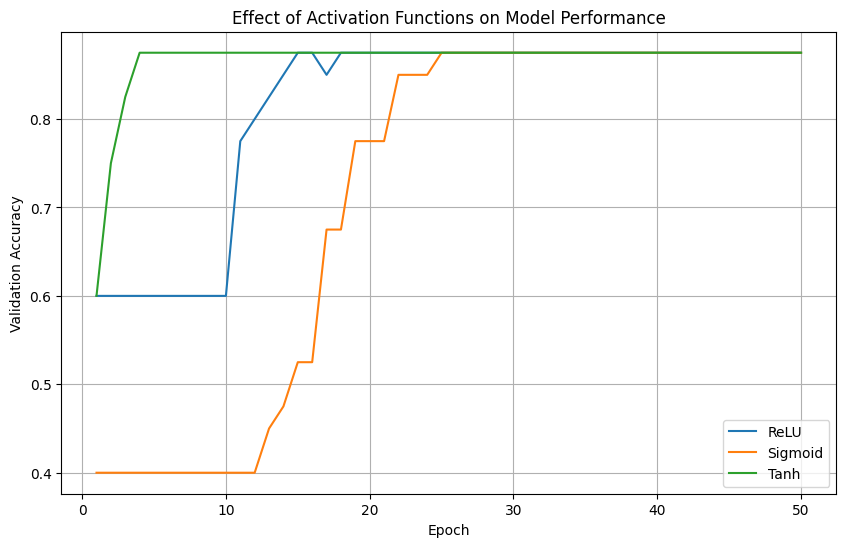

In [14]:
# Plot comparison of activation functions
plt.figure(figsize=(10, 6))
for result in activation_results:
    plt.plot(range(1, len(result['accuracies']) + 1), result['accuracies'], label=f"{result['activation']}")

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Effect of Activation Functions on Model Performance')
plt.legend()
plt.grid(True)
plt.show()

### Effect of Different Network Architectures

In [15]:
# Compare different network architectures
architectures = [
    [4],          # One hidden layer with 4 neurons
    [16],         # One hidden layer with 16 neurons
    [8, 4],       # Two hidden layers with 8 and 4 neurons
    [16, 8],      # Two hidden layers with 16 and 8 neurons
    [32, 16, 8]   # Three hidden layers
]

architecture_results = []

for arch in architectures:
    # Create model
    model = SimpleNN(
        input_dim=X_train_scaled.shape[1], 
        hidden_layers=arch,
        activation_function='ReLU', 
        regularization='None', 
        reg_rate=0.01
    )
    
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    train_losses, val_losses, accuracies = train_model(
        X_train_scaled, y_train, X_val_scaled, y_val, 
        50, 0.01, model, criterion, optimizer
    )
    
    architecture_results.append({
        'architecture': str(arch),
        'final_accuracy': accuracies[-1],
        'train_losses': train_losses,
        'val_losses': val_losses,
        'accuracies': accuracies
    })
    
    print(f"Architecture {arch} - Final accuracy: {accuracies[-1]:.4f}")

Architecture [4] - Final accuracy: 0.8750
Architecture [16] - Final accuracy: 0.8750
Architecture [8, 4] - Final accuracy: 0.8750
Architecture [16, 8] - Final accuracy: 0.8750
Architecture [32, 16, 8] - Final accuracy: 0.8750


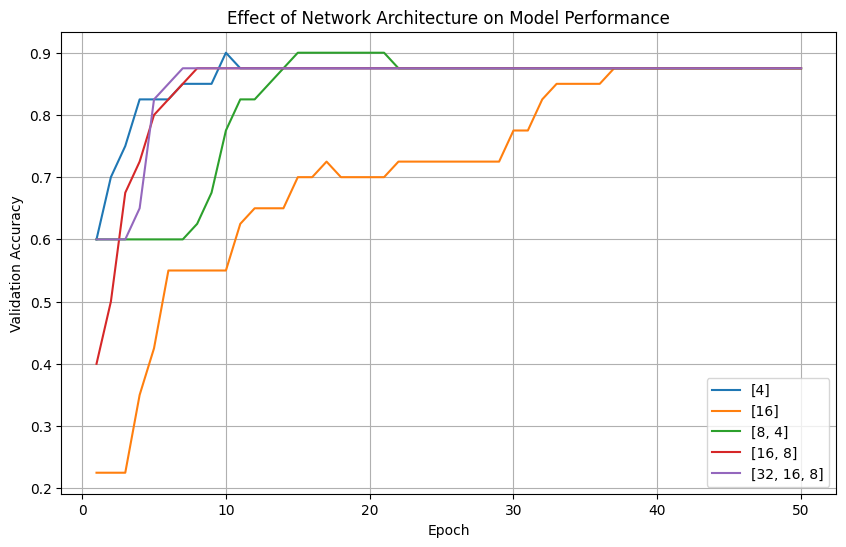

In [16]:
# Plot comparison of architectures
plt.figure(figsize=(10, 6))
for result in architecture_results:
    plt.plot(range(1, len(result['accuracies']) + 1), result['accuracies'], label=f"{result['architecture']}")

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Effect of Network Architecture on Model Performance')
plt.legend()
plt.grid(True)
plt.show()

### Effect of Different Regularization Techniques

In [17]:
# Compare different regularization techniques
regularization_types = ['None', 'L1', 'L2']
reg_results = []

for reg_type in regularization_types:
    # Create model
    model = SimpleNN(
        input_dim=X_train_scaled.shape[1], 
        hidden_layers=[16, 8],
        activation_function='ReLU', 
        regularization=reg_type, 
        reg_rate=0.01
    )
    
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    train_losses, val_losses, accuracies = train_model(
        X_train_scaled, y_train, X_val_scaled, y_val, 
        50, 0.01, model, criterion, optimizer
    )
    
    reg_results.append({
        'regularization': reg_type,
        'final_accuracy': accuracies[-1],
        'train_losses': train_losses,
        'val_losses': val_losses,
        'accuracies': accuracies
    })
    
    print(f"Regularization {reg_type} - Final accuracy: {accuracies[-1]:.4f}")

Regularization None - Final accuracy: 0.8750
Regularization L1 - Final accuracy: 0.8750
Regularization L2 - Final accuracy: 0.8750


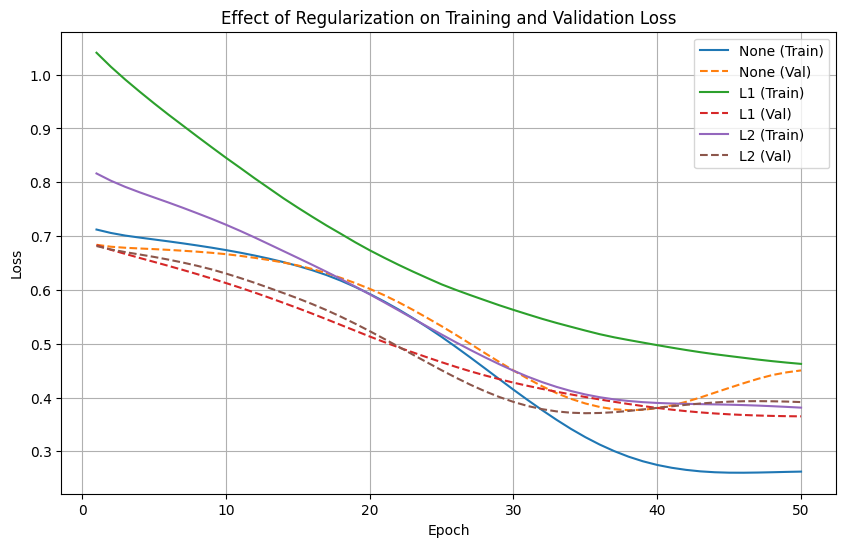

In [18]:
# Plot comparison of regularization techniques
plt.figure(figsize=(10, 6))
for result in reg_results:
    plt.plot(range(1, len(result['train_losses']) + 1), result['train_losses'], label=f"{result['regularization']} (Train)")
    plt.plot(range(1, len(result['val_losses']) + 1), result['val_losses'], linestyle='--', label=f"{result['regularization']} (Val)")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Effect of Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

In this notebook, we explored the fundamentals of Artificial Neural Networks for classification tasks. We implemented a configurable neural network model using PyTorch and experimented with different architectures, activation functions, and regularization techniques.

Key observations:
1. **Architecture**: Deeper networks with more neurons typically have greater learning capacity but may require more data and time to train properly.
2. **Activation Functions**: ReLU is generally faster to train but can suffer from "dying" neurons. Sigmoid and Tanh provide smooth outputs but can suffer from vanishing gradients.
3. **Regularization**: L1 and L2 regularization help prevent overfitting, with L1 promoting sparsity and L2 keeping weights small.

These basic principles form the foundation for more complex deep learning models like Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs).